In [ ]:
!unzip -q "/content/drive/MyDrive/RSICD.zip" -d "/content"

In [ ]:
!pip install nltk tqdm pycocoevalcap --quiet
import nltk
nltk.download('punkt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Set your paths to dataset here
image_folder = '/content/RSICD/images'
json_path = '/content/RSICD/sentences/Dataset.json'


In [ ]:
import os
import json
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from torch import nn
from tqdm import tqdm
from collections import Counter
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4
        for sentence in sentence_list:
            tokens = nltk.tokenize.word_tokenize(sentence.lower())
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized_text = nltk.tokenize.word_tokenize(text.lower())
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized_text]

class RSICDDataset(Dataset):
    def __init__(self, root_dir, json_path, transform, vocab):
        self.root_dir = root_dir
        self.vocab = vocab
        self.transform = transform
        with open(json_path, 'r') as f:
            data = json.load(f)['images']

        self.data = []
        captions = []

        for img_data in data:
            img_file = img_data['filename']
            for caption in img_data['sentences']:
                cap = caption['raw']
                captions.append(cap)
                self.data.append((img_file, cap))

        self.vocab.build_vocabulary(captions)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return image, torch.tensor(numericalized_caption)

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images, captions = zip(*batch)
        images = torch.stack(images)
        captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return images, captions

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet = resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


def generate_caption(encoder, decoder, image, vocab, max_len=20):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        feature = encoder(image.unsqueeze(0).to(device))  # shape: [1, embed_size]
        states = None
        inputs = feature
        caption = [vocab.stoi["<SOS>"]]

        for _ in range(max_len):
            last_word = torch.tensor([caption[-1]]).to(device)
            embedded = decoder.embed(last_word).unsqueeze(1)  # shape: [1, 1, embed_size]

            if inputs.dim() == 2:
                inputs = inputs.unsqueeze(1)  # shape: [1, 1, embed_size]

            inputs_combined = torch.cat((inputs, embedded), dim=1)  # shape: [1, 2, embed_size]
            outputs, states = decoder.lstm(inputs_combined, states)
            output = decoder.linear(outputs[:, -1, :])  # shape: [1, vocab_size]

            predicted = output.argmax(dim=1).item()

            if predicted == vocab.stoi["<EOS>"]:
                break
            caption.append(predicted)
            inputs = torch.zeros_like(feature)  # dummy input for next step

        return [vocab.itos[idx] for idx in caption[1:]]

In [ ]:
def train_model(encoder, decoder, criterion, optimizer, dataloader, vocab, num_epochs=5):
    encoder.train()
    decoder.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for imgs, captions in tqdm(dataloader):
            imgs, captions = imgs.to(device), captions.to(device)

            # Forward pass
            features = encoder(imgs)
            outputs = decoder(features, captions[:, :-1])  # input = all tokens except last

            # Align predictions and targets
            outputs = outputs[:, 1:, :]  # ignore first timestep (image feature output)
            targets = captions[:, 1:]   # target = all tokens except <SOS>

            loss = criterion(outputs.reshape(-1, outputs.shape[2]), targets.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")


def evaluate_model(encoder, decoder, dataloader, vocab):
    references = []
    hypotheses = []

    for imgs, captions in tqdm(dataloader):
        imgs = imgs.to(device)
        for img, caption in zip(imgs, captions):
            pred = generate_caption(encoder, decoder, img, vocab)
            target = [vocab.itos[idx.item()] for idx in caption if idx.item() not in {vocab.stoi["<PAD>"], vocab.stoi["<SOS>"], vocab.stoi["<EOS>"]}]
            references.append([" ".join(target)])
            hypotheses.append(" ".join(pred))

    # Format for pycocoevalcap
    gts = {i: [references[i][0]] for i in range(len(references))}
    res = {i: [hypotheses[i]] for i in range(len(hypotheses))}

    # BLEU expects tokenized references and hypotheses
    print("BLEU-1:", corpus_bleu([[ref[0].split()] for ref in references], [hyp.split() for hyp in hypotheses], weights=(1, 0, 0, 0)))
    print("BLEU-4:", corpus_bleu([[ref[0].split()] for ref in references], [hyp.split() for hyp in hypotheses], weights=(0.25, 0.25, 0.25, 0.25)))

    meteor_scorer = Meteor()
    rouge_scorer = Rouge()
    cider_scorer = Cider()

    print("METEOR:", meteor_scorer.compute_score(gts, res)[0])
    print("ROUGE-L:", rouge_scorer.compute_score(gts, res)[0])
    print("CIDEr:", cider_scorer.compute_score(gts, res)[0])


In [ ]:
 nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def main():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    vocab = Vocabulary(freq_threshold=5)
    dataset = RSICDDataset(root_dir=image_folder,
                           json_path=json_path,
                           transform=transform,
                           vocab=vocab)

    # Optional: reduce dataset for testing
    # from random import sample
    # dataset.data = sample(dataset.data, 1000)

    pad_idx = vocab.stoi["<PAD>"]
    dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True,
                            collate_fn=MyCollate(pad_idx))

    embed_size = 256
    hidden_size = 512
    vocab_size = len(vocab.itos)
    num_layers = 1

    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    params = list(decoder.parameters()) + list(encoder.resnet.fc.parameters())
    optimizer = torch.optim.Adam(params, lr=3e-4)

    # Train
    train_model(encoder, decoder, criterion, optimizer, dataloader, vocab, num_epochs=5)

    # Evaluate
    evaluate_model(encoder, decoder, dataloader, vocab)

main()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]
100%|██████████| 1707/1707 [04:38<00:00,  6.12it/s]


Epoch [1/5], Loss: 2.0757


100%|██████████| 1707/1707 [04:36<00:00,  6.18it/s]


Epoch [2/5], Loss: 1.4345


100%|██████████| 1707/1707 [04:36<00:00,  6.18it/s]


Epoch [3/5], Loss: 1.2378


100%|██████████| 1707/1707 [04:37<00:00,  6.15it/s]


Epoch [4/5], Loss: 1.1101


100%|██████████| 1707/1707 [04:34<00:00,  6.22it/s]


Epoch [5/5], Loss: 1.0090


100%|██████████| 1707/1707 [12:05<00:00,  2.35it/s]


BLEU-1: 0.24466029331712838
BLEU-4: 0.04180443284841567
METEOR: 0.1298246873232005
ROUGE-L: 0.3545778949448524
CIDEr: 0.6124001973345854


In [ ]:
import json
from collections import Counter
import nltk
nltk.download('punkt')

class Vocabulary:
    def __init__(self, freq_threshold):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}

    def __len__(self):
        return len(self.itos)

    def tokenizer(self, text):
        return nltk.word_tokenize(text.lower())

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            frequencies.update(tokens)

        for word, freq in frequencies.items():
            if freq >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1

    def numericalize(self, text):
        tokenized = self.tokenizer(text)
        return [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokenized]

# Load your RSICD JSON
with open('/content/RSICD/sentences/Dataset.json', 'r') as f:
    data = json.load(f)

# Collect all captions
captions_list = []
for item in data['images']:
    for cap in item['sentences']:
        captions_list.append(cap['raw'])

# Build vocab again
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(captions_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set same values used during training
embed_size = 256
hidden_size = 512
num_layers = 1

# Recreate vocab (assuming you saved it or still have the class loaded)
# Example if vocab is still in memory:
# If not, you'll need to reload vocab from the original JSON/RSICD captions loader.

# Reinitialize models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Load trained weights if you saved them
# torch.load('encoder.pth') and 'decoder.pth' must be the actual path if saved
# torch.save(encoder.state_dict(), "encoder.pth")
# torch.save(decoder.state_dict(), "decoder.pth")

# Uncomment below if you saved them after training
# encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
# decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

encoder.eval()
decoder.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DecoderRNN(
  (embed): Embedding(1311, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=1311, bias=True)
)

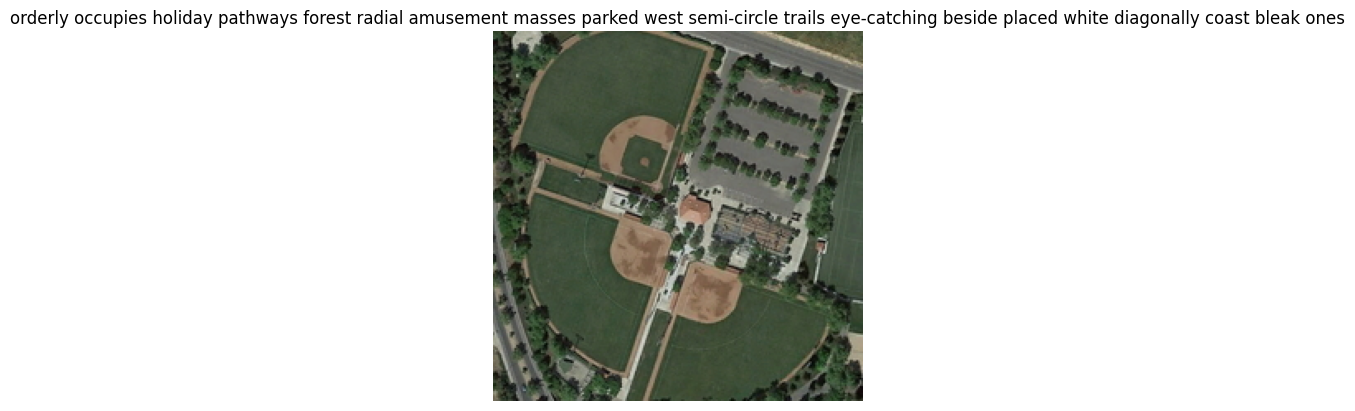

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define transform (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    return image, image_tensor

# Full pipeline: load image -> generate caption -> display
def caption_and_show(image_path, encoder, decoder, vocab):
    image, image_tensor = load_image(image_path)
    words = generate_caption(encoder, decoder, image_tensor, vocab)
    caption = ' '.join(words)

    # Show image and caption
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

# Example usage
image_path = '/content/baseballfield_210.jpg'  # Replace with your test image path
caption_and_show(image_path, encoder, decoder, vocab)


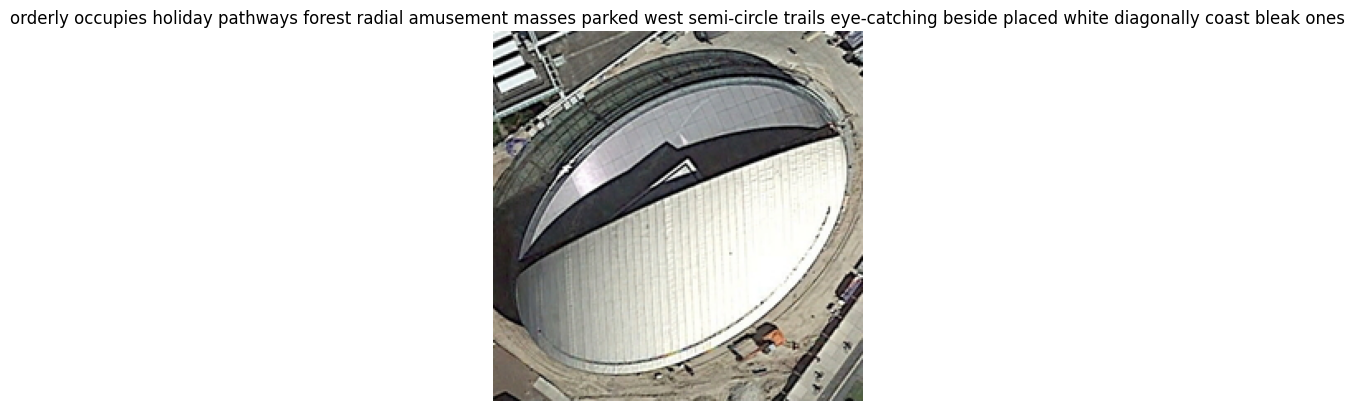

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define transform (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    return image, image_tensor

# Full pipeline: load image -> generate caption -> display
def caption_and_show(image_path, encoder, decoder, vocab):
    image, image_tensor = load_image(image_path)
    words = generate_caption(encoder, decoder, image_tensor, vocab)
    caption = ' '.join(words)

    # Show image and caption
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

# Example usage
image_path = '/content/center_213.jpg'  # Replace with your test image path
caption_and_show(image_path, encoder, decoder, vocab)


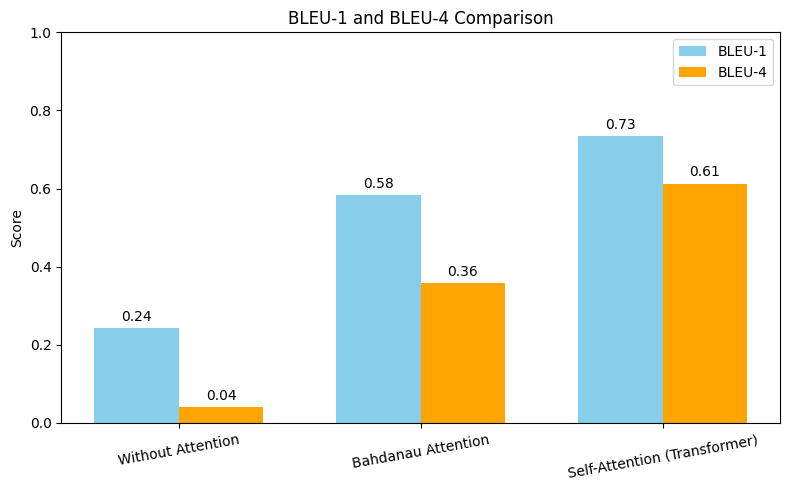

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example BLEU scores (you'll replace these with your actual results)
bleu1_scores = [0.244, 0.584, 0.735]  # Replace with your BLEU-1 values
bleu4_scores = [0.041, 0.359, 0.613]  # Replace with your BLEU-4 values

models = ['Without Attention', 'Bahdanau Attention', 'Self-Attention (Transformer)']
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, bleu1_scores, width, label='BLEU-1', color='skyblue')
bars2 = ax.bar(x + width/2, bleu4_scores, width, label='BLEU-4', color='orange')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Score')
ax.set_title('BLEU-1 and BLEU-4 Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=10)
ax.set_ylim(0, 1)
ax.legend()

# Optional: Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()
